In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import gudhi as gd
from utilsTopology import *
from utilsBaricentricNeuralNetwork import *
from utils import *
fontsize=16
from tqdm import tqdm
import yfinance as yf

plt.rcParams.update({
    "axes.titlesize": 14,    # Tamaño del título
    "axes.labelsize": fontsize,    # Tamaño de xlabel y ylabel
})

C:\Users\cimagroup\AppData\Local\Temp\ipykernel_2060\3999059328.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.620857  72.681304  71.373233  71.627107  135480400
2020-01-03  71.914818  72.676447  71.689957  71.847118  146322800
2020-01-06  72.487854  72.526541  70.783256  71.034717  118387200
2020-01-07  72.146942  72.753823  71.926915  72.497529  108872000
2020-01-08  73.307518  73.609752  71.849540  71.849540  132079200


<Figure size 1400x700 with 0 Axes>

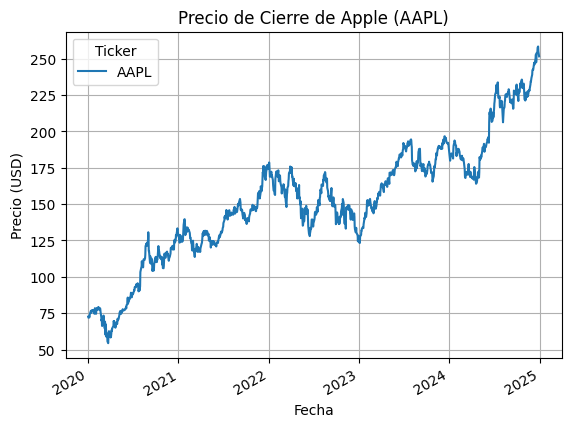

In [9]:
ticker_symbol = "AAPL" # Apple Inc.
start_date = "2020-01-01"
end_date = "2024-12-31"

# Descarga los datos históricos
stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Muestra las primeras filas del DataFrame
print(stock_data.head())

# Visualiza el precio de cierre
plt.figure(figsize=(14, 7))
stock_data['Close'].plot(title=f"Precio de Cierre de Apple ({ticker_symbol})")
plt.xlabel("Fecha")
plt.ylabel("Precio (USD)")
plt.grid(True)
plt.show()

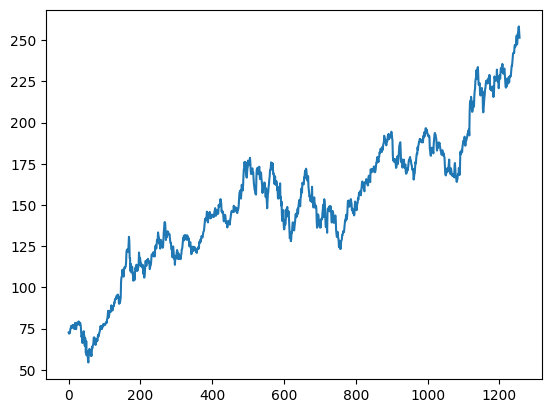

(1257, 1)


In [11]:
AppleCloseValues = stock_data['Close'].values
plt.plot(AppleCloseValues)
plt.show()
print(AppleCloseValues.shape)

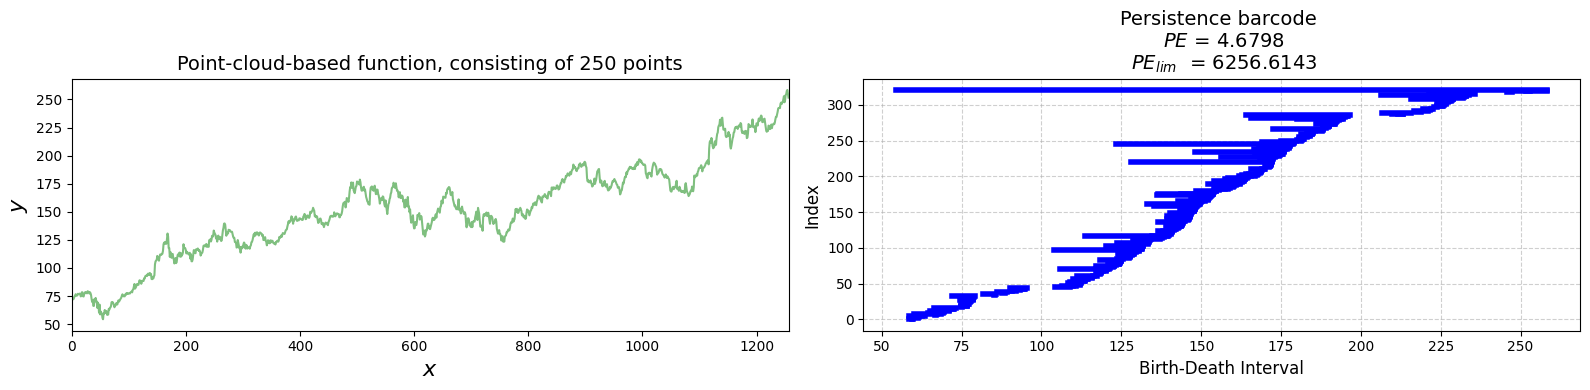

In [16]:
domain =[0,AppleCloseValues.shape[0]-1]

x_train, y_train = np.arange(0, len(AppleCloseValues)), AppleCloseValues.reshape(-1)
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)
stbase = gd.SimplexTree()
for i in range(len(AppleCloseValues)-1):
    stbase.insert([i,i+1], -1e10) # here we define that each element is connected to the next one, since what we have is a line formed by the points of the point cloud
layer = LowerStarLayer(simplextree=stbase)
dgms = layer.call(tf.Variable(y_train))
dgmRef = dgms[0][0]

entropyRef=persistent_entropy_tf(dgmRef)
entropyRefLim=persistent_entropy_lim_tf(dgmRef)


lim="lim"
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
axs[0].plot(x_train, y_train,"g-", alpha=0.5)
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$y$')
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Point-cloud-based function, consisting of 250 points')
plot_persistent_barcode(dgmRef,ax=axs[1])
axs[1].set_title(axs[1].get_title() + f" \n $PE$ = {round(entropyRef.numpy().item(),4)}")
axs[1].set_title(axs[1].get_title() + " \n $PE_{lim}$ " + f" = {round(entropyRefLim.numpy().item(),4)}")
fig.tight_layout()
plt.show()

100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


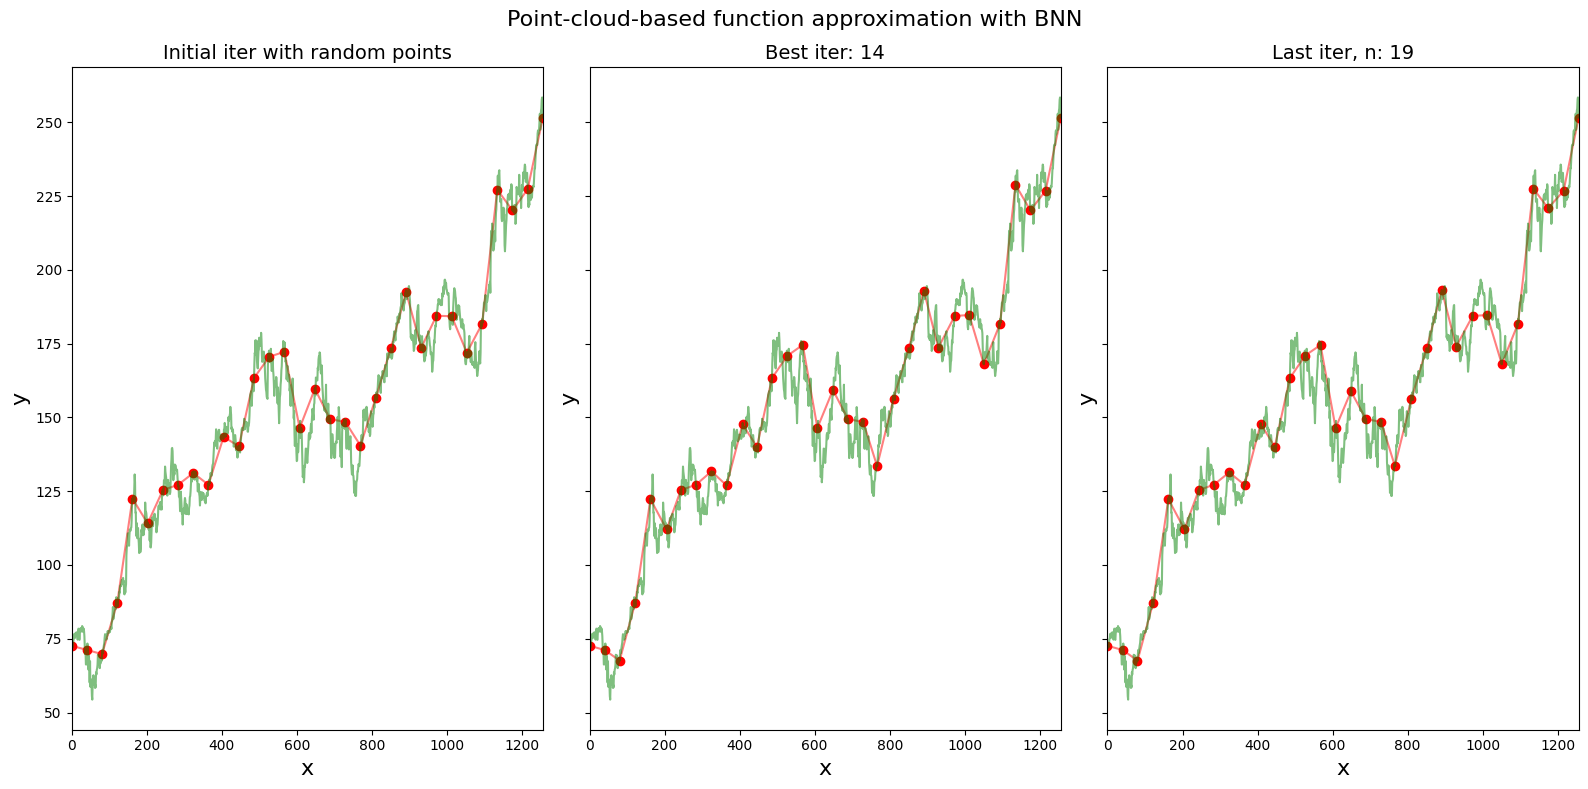

In [24]:
domain =[0,AppleCloseValues.shape[0]-1]

x_train, y_train = np.arange(0, len(AppleCloseValues)), AppleCloseValues.reshape(-1)
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)
stbase = gd.SimplexTree()
for i in range(len(AppleCloseValues)-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)
dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]

entropyRef=persistent_entropy_tf(dgmRef)
entropyRefLim=persistent_entropy_lim_tf(dgmRef)

num_points_aprox=30
x_points = tf.Variable(tf.cast(tf.linspace(0,len(AppleCloseValues)-1,num_points_aprox+2), dtype=tf.float32) ,trainable=True)
# y_points = tf.math.sin(x_points)
# points = tf.stack([x_points, y_points], axis=1)

min_diff_entropy = float('inf')
num_iter = 20  
best_iter = 0

metricas = {
    "$MSE$": [],
    "$L_{PE_{lim}}$": [],
}

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

for epoch in tqdm(range(num_iter)):
    with tf.GradientTape() as tape:
        tape.watch(x_points)
        y_points = interpolation_tf(x_train,y_train, x_points)
        points = tf.stack([x_points, y_points], axis=1)
        model = BaricentricSigmaNetworkTf(points)
        y_aprox = model(x_train)
        dgmsAprox = layer.call(y_aprox)
        dgmAprox = dgmsAprox[0][0]
        lossFunction = PersistentEntropyLossLimTF()
        entropyLoss = lossFunction(dgmRef,dgmAprox)

    
    dgmsAprox = layer.call(y_aprox)
    dgmAprox = dgmsAprox[0][0]
    entropyAproxActual=persistent_entropy_tf(dgmAprox)
    entropyAproxActualLim=persistent_entropy_lim_tf(dgmAprox)
    
    
    metricas["$L_{PE_{lim}}$"].append(entropyLoss.numpy().item())


    gradients = tape.gradient(entropyLoss,[x_points])
    gradients[0] = tf.tensor_scatter_nd_update(gradients[0], [[0], [num_points_aprox + 2 - 1]], [0.0, 0.0]) # we keep constant the two extrema points
    mseActual = tf.keras.losses.MSE(y_train,y_aprox)
    metricas["$MSE$"].append(mseActual.numpy().item())
    
    if epoch == 0:
        initial_model = model
        initial_x_points = tf.identity(x_points)
        initial_y_points = tf.identity(y_points)
        initial_entropy = entropyAproxActual
        initial_entropyLim = entropyAproxActualLim

    
    if entropyLoss < min_diff_entropy:
        min_diff_entropy = entropyLoss
        no_improvement_counter = 0
        best_x_points = tf.identity(x_points)
        best_y_points = tf.identity(y_points)
        best_model = model
        best_iter = epoch
        best_entropy = entropyAproxActual
        best_entropyLim = entropyAproxActualLim
    

    if epoch < num_iter - 1:
        optimizer.apply_gradients(zip(gradients, [x_points]))
        entropyAproxPrevio = entropyAproxActual
        msePrevio = mseActual
    else:
        last_model = model
        last_x_points = tf.identity(x_points)
        last_y_points = tf.identity(y_points)
        last_entropy = entropyAproxActual
        last_entropyLim = entropyAproxActualLim
        
    
metricasPE_wnoise  = metricas.copy()

fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)
axs[0].plot(x_train, initial_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(initial_entropy.numpy().item(),6)}$', alpha=0.5)
axs[0].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[0].scatter(initial_x_points, initial_y_points, color="red", label="BNN Points creation")
axs[0].set_xlabel('x', fontsize=fontsize)
axs[0].set_ylabel('y', fontsize=fontsize)
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Initial iter with random points',fontsize=14)
# axs[0].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[1].plot(x_train, best_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(best_entropy.numpy().item(),6)}$', alpha=0.5)
axs[1].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[1].scatter(best_x_points, best_y_points, color="red", label="BNN Points creation")
axs[1].set_xlabel('x', fontsize=fontsize)
axs[1].set_ylabel('y', fontsize=fontsize)
axs[1].set_xlim((domain[0],domain[1]))
axs[1].set_title(f'Best iter: {best_iter}',fontsize=14)
# axs[1].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[2].plot(x_train, last_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(last_entropy.numpy().item(),6)}$', alpha=0.5)
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[2].scatter(last_x_points, last_y_points, color="red", label="BNN Points creation")
axs[2].set_xlabel('x', fontsize=fontsize)
axs[2].set_ylabel('y', fontsize=fontsize)
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'Last iter, n: {num_iter-1}',fontsize=14)
# axs[2].legend(loc="lower left",fontsize=12, framealpha=0.5)
plt.suptitle("Point-cloud-based function approximation with BNN",fontsize=16)
plt.tight_layout()
plt.show()

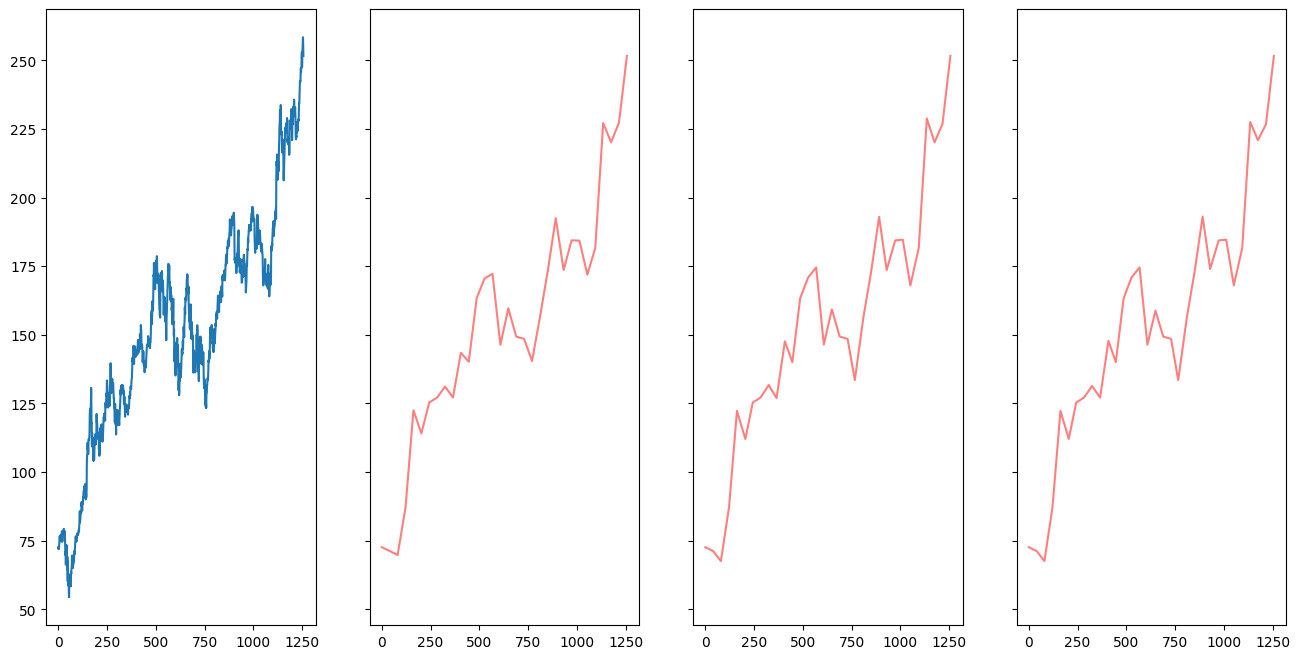

In [25]:
fig, axs = plt.subplots(1, 4, figsize=(16, 8), sharex=True, sharey=True)
axs[0].plot(AppleCloseValues)
axs[1].plot(initial_x_points.numpy(), initial_y_points.numpy(), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(initial_entropy.numpy().item(),6)}$', alpha=0.5)
axs[2].plot(best_x_points.numpy(), best_y_points.numpy(), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(best_entropy.numpy().item(),6)}$', alpha=0.5)
axs[3].plot(last_x_points.numpy(), last_y_points.numpy(), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(last_entropy.numpy().item(),6)}$', alpha=0.5)